<a href="https://colab.research.google.com/github/Ayesha-Imr/Graph-RAG-Automation-ApertureDB-Gemini/blob/main/Notebooks/LOCAL_ApertureDB_Knowledge_Graph_with_Gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Knowledge Graphs with ApertureDB and Gemini Part 1 and Part 2

Welcome to this tutorial on building a knowledge graph from your documents using ApertureDB and Gemini 2.5 Flash!

Knowledge graphs are powerful ways to organize data visually, connecting entities through clear, meaningful relationships. They’re especially helpful for making Retrieval-Augmented Generation (RAG) systems smarter, providing accurate, context-rich responses. Companies using knowledge graphs with RAG have seen noticeable improvements, including nearly 30% faster customer issue resolutions ([arxiv.org](https://arxiv.org/abs/2404.17723)) and better transparency in how AI models generate answers.

For managing and querying our knowledge graph, we're using [ApertureDB](https://www.aperturedata.io/), a versatile multimodal database built specifically for handling structured metadata alongside images, videos, and other rich media. ApertureDB lets us quickly set up and explore complex relationships between different data types, which makes analyzing and retrieving information intuitive and efficient.

We’ve chosen [Gemini 2.5 Flash](https://cloud.google.com/vertex-ai/generative-ai/docs/models/gemini/2-5-flash) as our LLM of choice because of its large context window and fast response times, perfect for smoothly processing and extracting detailed insights from lengthy documents.

LangChain has been utilised to orchestrate the graph-generation workflow , particularly its  RunnableParallel feature to run multiple tasks side-by-side, speeding up the entire process.

For the input data I used to build a knowledge in this tutorial are my Cloud Computing lecture course notes in PDF form (I have my exams coming up so this was like killing two birds with one stone!). The PDF consists of 42 pages (!) so this shows the impressive capability of this workflow for knowledge graph creation.

While in this tutorial we will only explore how to CREATE a knowledge graph, in the next part, we'll see how to use this created knowledge graph for RAG (Retrieval Augmented Generation).

Let's get started and build your very own knowledge graph!

NOTE: This notebook consists of two parts; [Part 1](https://colab.research.google.com/drive/1HoaDwiVsj9QWnSQq2GKMhNrRf0NHp2sw#scrollTo=7ZPjLqL-jQ7K) and [Part 2](https://colab.research.google.com/drive/1HoaDwiVsj9QWnSQq2GKMhNrRf0NHp2sw#scrollTo=2_LWo5Xzjb4w).

# Part 1

## Setup
Install dependencies

In [1]:
!pip install -q --upgrade langchain langchain-google-genai langchain-community langchain-text-splitters pydantic aperturedb pypdf tqdm pyvis udocker

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.0/141.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.7/309.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.6/119.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 130.6 MB/s eta 0:00:00
   ━━

### Local ApertureDB session setup via udocker

The next two cells enable persistence of your DB data in google drive so you can use it across sessions and notebooks. In case you don't ant to persist the data, feel free to skip these cells. But do note you will need this data in later Graph RAG notebooks.

In [2]:
# Run this only if you need to persist the data (prerequisite for Graph RAG notebooks)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
DATA_ROOT = "/content/drive/MyDrive/aperturedb_data"
!mkdir -p $DATA_ROOT/db

In [4]:
!udocker --allow-root install
!udocker --allow-root install

Info: creating repo: /root/.udocker
Info: udocker command line interface 1.3.17
Info: searching for udockertools >= 1.2.11
Info: installing udockertools 1.2.11
Info: installation of udockertools successful


In [5]:
!udocker --allow-root pull aperturedata/aperturedb-community:latest
!udocker --allow-root create --name=aperturedb aperturedata/aperturedb-community:latest

Info: downloading layer sha256:7c84311f635af4c4a0fec53e53c35b7b388a8b7e40025346a1d4af37423ea2c2
Info: downloading layer sha256:a6e6f81788d18a6a24869a662a78e4798c46eba38d0cca171080f1e131146a16
Info: downloading layer sha256:6c6f170a129049940a474f88f5fc649d7d96700ef0748bbc590476942c609949
Info: downloading layer sha256:9b3453b1064fb34bae3e701ecd6cfce41e99f8fc037857b7c9de26f917ad8840
Info: downloading layer sha256:5090e15fdc6a26ebc57cdfff090b7090d1020672ce22b4a290451acc9c16da6d
Info: downloading layer sha256:c2bf41e51776f1206dd05060633eada7174bc768aa6f062cc6fa3b5def95ca94
Info: downloading layer sha256:e17caecd6bd74e6c419f0d21e9522006fded22eedf72be6b9046819a6265903c
Info: downloading layer sha256:aece8493d3972efa43bfd4ee3cdba659c0f787f8f59c82fb3e48c87cbb22a12e
ee7b5c59-ff55-3861-94b2-c1c575dc6358


In [38]:
!nohup udocker --allow-root run \
    --publish=55555:55555 \
    --env="ADB_MASTER_KEY=admin" \
    --env="ADB_FORCE_SSL=false" \
    --volume=$DATA_ROOT/db:/aperturedb/db \
    aperturedb  > /content/adb_server.log 2>&1 &

# Uncomment and run the following if you do not want data persistence in google drive (and comment out the above)

# !nohup udocker --allow-root run \
#        --publish=55555:55555 \
#        --env="ADB_MASTER_KEY=admin" \
#        --env="ADB_FORCE_SSL=false" \
#        aperturedb > /content/adb_server.log 2>&1 &

In [7]:
import time
time.sleep(15)  # Adding a 15 second delay for udocker to start

In [39]:
!tail -n 15 /content/adb_server.log | sed -e 's/^/LOG │ /'

LOG │ ApertureDB Server, Version: 0.18.10, Branch: feature/community-docker, Commit: 728440c99395bca1a3346dc8e4d51917a8d16764


In [43]:
!lsof -nP -iTCP:55555

COMMAND    PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
apertured 3893 root   18u  IPv4 106004      0t0  TCP *:55555 (LISTEN)


Connect to ApertureDB client

In [44]:
from aperturedb import Connector
client = Connector.Connector(
    host="127.0.0.1", port=55555,
    user="admin",  password="admin",
    use_ssl=False
)
status = client.query([{"GetStatus": {}}], [])
print(status)

([{'GetStatus': {'info': 'OK', 'status': 0, 'system': 'ApertureDB', 'version': '0.18.10'}}], [])


Check connection

In [45]:
 query = [{
        "GetSchema": {
        }
    }]

response, _ = client.query(query, [])
print(response)

[{'GetSchema': {'connections': None, 'entities': None, 'refreshed': '2025-07-19T18:57:46.090295Z', 'status': 0}}]


Import the required libraries

In [13]:
# Core imports
import os
import json
import time
import socket
from typing import Dict, List, Any
from tqdm import tqdm

# LangChain and LLM
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnableLambda

# Data models and utilities
from pydantic import BaseModel, Field
from google.colab import userdata, files
from aperturedb import Connector
from aperturedb.ParallelLoader import ParallelLoader
import networkx as nx
from pyvis.network import Network
from IPython.display import HTML, display

Set environment variables

In [14]:
os.environ['GOOGLE_API_KEY'] = userdata.get("GOOGLE_API_KEY")

# Uncomment the following if using ApertureB Cloud
# db_host = userdata.get("APERTUREDB_HOST")
# db_password = userdata.get("APERTUREDB_PASSWORD")

Initialize Gemini 2.5 Flash LLM using LangChain's ChatGoogleGenerativeAI

In [15]:
# Initialize LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-05-20",
    temperature=0,
    max_retries=2
)

## Utility Functions
Let's define some reusable utility functions that we'll use throughout our workflow for various purposes

The utility functions handle:

* PDF loading and text processing
* LLM retry logic (used across all steps)
* File I/O operations
* Database connectivity
* Common data transformations
* Parallel processing

In [16]:
def load_pdf():
    """Load PDF content as single string."""
    uploaded = files.upload()
    if not uploaded:
        raise ValueError("No file uploaded")

    pdf_path = list(uploaded.keys())[0]
    loader = PyPDFLoader(pdf_path, mode="single")
    docs = loader.load()

    content = docs[0].page_content if docs else ""
    print(f"Loaded PDF: {len(content):,} characters")
    return content

def split_text(text, chunk_size=5000, overlap=500):
    """Split text into overlapping chunks."""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        separators=["\n\n", "\n", ". ", " "]
    )
    chunks = splitter.create_documents([text])

    for i, chunk in enumerate(chunks):
        chunk.metadata["chunk_id"] = i

    print(f"Split into {len(chunks)} chunks")
    return chunks

def retry_llm_call(func, max_retries=3):
    """Execute LLM function with retry logic."""
    for attempt in range(max_retries):
        try:
            return func()
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"Retry {attempt + 1}/{max_retries}")
                time.sleep(2)
            else:
                raise e

def save_json(data, filename):
    """Save data to JSON file."""
    with open(filename, "w") as f:
        json.dump(data, f, indent=2)
    print(f"Saved {filename}")

def load_json(filename):
    """Load data from JSON file."""
    try:
        with open(filename, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"{filename} not found")
        return None

def process_in_parallel(processor_func, data_list, max_concurrency=6):
    """Generic parallel processing utility using RunnableLambda.batch()."""
    processor = RunnableLambda(processor_func)

    print(f"Processing {len(data_list)} items in parallel...")

    with tqdm(total=len(data_list), desc="Processing") as pbar:
        # Process in batches
        batch_size = min(max_concurrency, len(data_list))
        all_results = []

        for i in range(0, len(data_list), batch_size):
            batch = data_list[i:i + batch_size]

            try:
                batch_results = processor.batch(batch, config={"max_concurrency": max_concurrency})
                all_results.extend(batch_results)
            except Exception as e:
                print(f"Batch error: {e}")
                # Add empty results for failed batch
                all_results.extend([{} for _ in batch])

            pbar.update(len(batch))

    return all_results

## Load document and extract text
Let's load our PDF document and check its extracted contents

In [17]:
document_content = load_pdf()

Saving Cloud Computing Copy Lecture Notes.pdf to Cloud Computing Copy Lecture Notes.pdf
Loaded PDF: 48,269 characters


In [18]:
# check out first 1000 characters
print(f"First 1000 characters: {document_content[:1000]}")

First 1000 characters: Cloud Computing Lecture Notes 
Distributed Computing/Systems 
Definition: 
Distributed computing refers to a system where computing resources are distributed 
across multiple locations rather than being centralized in a single system. This enables 
task distribution and efficient resource utilization. 
Why Use Distributed Systems? 
• Scalability Issues: Traditional computing faces bottlenecks due to hardware 
limitations, whereas distributed systems allow for hardware scaling. 
• Connected Devices: In a networked system, connected devices communicate, but 
this does not necessarily make them distributed. 
• IoT (Internet of Things): IoT is one of the largest examples of distributed computing. 
• Multi-layered System Design: Distributed computing enables systems to function 
in multiple layers, with each layer acting as a distributed entity. 
• User Perspective: Although the system consists of multiple machines, distributed 
computing presents a unified system to 

This step is optional, but you can add the entire PDF to the DB instance as a text blob, and then you may connect it to its extracted entities. This way, you can even have multiple related documents referring to the same entities.

In [20]:
def upload_pdf_to_db(pdf_path, client):
    """Upload PDF to ApertureDB as blob with metadata."""

    # Extract file name from path
    file_name = os.path.basename(pdf_path)

    # Read PDF as binary data
    with open(pdf_path, 'rb') as f:
        pdf_data = f.read()

    # Create upload query
    query = [{
        "AddBlob": {
            "properties": {
                "id": 0,
                "type": "pdf",
                "name": file_name,  # dynamically set file name
                "description": "Source document for knowledge graph creation",
                "upload_timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
            }
        }
    }]

    # Upload with binary data
    response, _ = client.query(query, [pdf_data])

    if response[0]["AddBlob"]["status"] == 0:
        print(f"PDF '{file_name}' uploaded to ApertureDB")
    else:
        print(f"PDF '{file_name}' upload failed")

    return response


In [46]:
# you can get the filepath of your recently uploaded file through your Files directory in Colab, right click then select "Copy path"
upload_response = upload_pdf_to_db("/content/Cloud Computing Copy Lecture Notes.pdf", client)

PDF 'Cloud Computing Copy Lecture Notes.pdf' uploaded to ApertureDB


## Step 1: Entity Class Schema Extraction
In the first step of the workflow, we identify the types of entities (classes) present in our document and their possible properties.


This Pydantic model defines the structure for our class schema output, ensuring the LLM returns properly formatted data.

In [47]:
# Define Pydantic model for class schema parser
class ClassSchema(BaseModel):
    """Class types and their properties."""
    classes: Dict[str, List[str]] = Field(
        description="Dictionary mapping class types to their possible properties"
    )

In [48]:
def extract_class_schema(text):
    """Extract entity classes and properties from text using LLM."""

    parser = JsonOutputParser(pydantic_object=ClassSchema)

    prompt = PromptTemplate(
        template="""
          You are the first agent in a multi-step workflow to build a Knowledge Graph from raw text.

          Workflow Steps Overview:
          1. Extract high-level class types and their properties from the text. [CURRENT STEP]
          2. Extract specific entities (instances of classes) and their properties based on the identified types.
          3. Deduplicate extracted entities and assign them unique identifiers.
          4. Identify and define relationships between the entities.
          5. Create a structured knowledge graph using the extracted entities and relationships.

          You are the FIRST agent in this workflow.

          YOUR TASK:
          - Identify high-level, general class types (e.g., Person, Company, Location, Event).
          - For each class type, list all the possible (available) properties it might have.
          - Focus on information that would be useful for structuring a knowledge graph.
          - Stay general — do not extract specific names, examples, or relationships.
          - Avoid unnecessary details or context-specific examples.

          FORMAT:
          - Return a valid JSON object.
          - Keys = class types (strings).
          - Values = lists of property names (strings).
          - Use double quotes for all keys and string values.
          - No extra explanation, text, or markdown formatting.

          EXAMPLES:
          {{
              "Person": ["name", "age", "email", "address"],
              "Company": ["name", "industry", "founded_date"],
              "Location": ["name", "coordinates", "population"]
          }}

          Text to process: {input}

          {format_instructions}

          Response:
          """,
          input_variables=["input"],
          partial_variables={"format_instructions": parser.get_format_instructions()},
      )

    # Build the chain
    chain = prompt | llm | parser

    def attempt_extraction():
        result = chain.invoke({"input": text})
        return result if isinstance(result, dict) else {"classes": result}

    return retry_llm_call(attempt_extraction)

Now we run the class extraction on our full document and display some of the results. Note that full results are also saved to step1_output.json file in your data folder.

In [49]:
# Extract classes
classes = extract_class_schema(document_content)

# Save results
save_json(classes, "step1_output.json")

# Extract the dictionary of classes
entity_classes = classes.get("classes", {})

# Display results
print(f"\nFound {len(entity_classes)} entity types:")
for entity_type, properties in entity_classes.items():
    preview = ', '.join(properties[:3])
    suffix = '...' if len(properties) > 3 else ''
    print(f"  • {entity_type}: {preview}{suffix}")

Saved step1_output.json

Found 8 entity types:
  • Concept: definition, key_aspects, use_cases...
  • System: type, definition, resource_distribution_model...
  • Software: name, type, function...
  • Hardware: type, configuration, operating_system...
  • Network: type, definition, connectivity_method...
  • Service: name, description, model_type...
  • Organization: name, type, offerings...
  • User: type, role, interaction_method...


## Step 2: Entity Instance Extraction
Extract actual entity instances from the document text using the discovered schema.

In [50]:
# Define Pydantic models for entity extraction
class ClassEntities(BaseModel):
    """Entities of a specific class type."""
    Class: str = Field(description="The class type name")
    Entities: Dict[str, Dict[str, Any]] = Field(
        description="Dictionary mapping entity names to their properties"
    )

class ChunkExtractionResult(BaseModel):
    """Result of entity extraction from a single chunk."""
    classes: List[ClassEntities] = Field(
        description="List of class types and their entities found in this chunk"
    )

In [51]:
# function to extract entity instances from a single text chunk
def extract_entities_from_chunk(chunk_data):
    """Extract entity instances from a single text chunk."""
    chunk_text, classes = chunk_data

    # Entity extraction result parser
    parser = JsonOutputParser(pydantic_object=ChunkExtractionResult)

    # Create prompt template for entity extraction
    prompt = PromptTemplate(
        template="""
        You are part of a multi-step workflow to build a Knowledge Graph from raw text.

        Workflow Steps Overview:
        1. Extract high-level class types and their properties from the text. [COMPLETED]
        2. Extract specific entities (instances of classes) and their properties from text chunks. [CURRENT STEP]
        3. Deduplicate extracted entities and assign them unique identifiers.
        4. Identify and define relationships between the entities.
        5. Create a structured knowledge graph using the extracted entities and relationships.

        YOUR TASK:
        You are processing a CHUNK of the full text. Focus ONLY on extracting CONCRETE ENTITIES (instances of classes) found in this chunk.

        GIVEN:
        1. A chunk of text
        2. A schema of class types and their possible properties

        INSTRUCTIONS:
        - Extract ALL entities (instances) of the predefined class types found in this chunk
        - For each entity, extract values for as many properties as are mentioned in the text
        - Be precise - only extract information explicitly stated in this chunk
        - Do NOT make up or infer missing properties
        - If a property is not mentioned, omit it from the output (don't include it with null/empty values)

        INPUT TEXT CHUNK:
        {chunk}

        CLASS TYPES AND THEIR PROPERTIES:
        {class_schema}

        FORMAT YOUR RESPONSE AS FOLLOWS:
        - Return a valid JSON object
        - For each class type found, include its name and an "Entities" object
        - "Entities" should be a dictionary where:
          - Keys are the entity names
          - Values are objects containing the (available) entity properties
        - Properties not mentioned should be omitted entirely
        - If no entities of a particular class type are found, do not include that class type

        {format_instructions}

        EXAMPLE RESPONSE FOR A CHUNK ABOUT PEOPLE AND COMPANIES:
        {{
        "classes": [
            {{
            "Class": "Person",
            "Entities": {{
                "John Doe": {{
                    "name": "John Doe",
                    "age": 35,
                    "email": "john@example.com"
                }},
                "Jane Smith": {{
                    "name": "Jane Smith",
                    "email": "jane@example.com"
                }}
            }}
            }},
            {{
            "Class": "Company",
            "Entities": {{
                "Google": {{
                    "industry": "Technology",
                    "founded": 1998
                }}
            }}
            }}
        ]
        }}
        Begin your extraction now: """,
    input_variables=["chunk", "class_schema"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    # Build the chain
    chain = prompt | llm | parser

    def attempt_extraction():
        return chain.invoke({
            "chunk": chunk_text,
            "class_schema": json.dumps(classes, indent=2)
        })

    return retry_llm_call(attempt_extraction)


In [52]:
# define function to merge the results of all parallel processes into a single unified list
def merge_entity_results(results_list):
    """Merge entity extraction results from multiple chunks."""
    merged = {}

    for result in results_list:
        if not isinstance(result, dict) or "classes" not in result:
            continue

        for class_data in result["classes"]:
            class_type = class_data.get("Class")
            entities = class_data.get("Entities", {})

            if class_type not in merged:
                merged[class_type] = {}

            # Merge entities from this chunk
            for entity_name, props in entities.items():
                if entity_name in merged[class_type]:
                    # Update with any new properties
                    merged[class_type][entity_name].update(props)
                else:
                    merged[class_type][entity_name] = props

    # Convert to expected format
    result = []
    for class_type, entities in merged.items():
        result.append({
            "Class": class_type,
            "Entities": entities
        })

    return result

Now let's extract entities from our full document using the previously identified classes and the extracted text.

In [53]:
# Split content into chunks
chunks = split_text(document_content)

# Prepare parallel processing data
chunk_data = [(chunk.page_content, entity_classes) for chunk in chunks]

# Extract entities using parallel processing utility (concurrently processing 6 chunks at a time - feel free to increase or decrease the concurrency)
results = process_in_parallel(extract_entities_from_chunk, chunk_data, max_concurrency=6)

# Merge all results
extracted_entities = merge_entity_results(results)

# Save results
save_json(extracted_entities, "step2_output.json")

# Display summary
total_entities = sum(len(class_obj["Entities"]) for class_obj in extracted_entities)
print(f"\nExtracted {total_entities} entities:")
for class_obj in extracted_entities:
    class_type = class_obj["Class"]
    entities = class_obj["Entities"]
    print(f"  • {class_type}: {len(entities)} instances")

Split into 11 chunks
Processing 11 items in parallel...


Processing: 100%|██████████| 11/11 [01:34<00:00,  8.60s/it]

Saved step2_output.json

Extracted 380 entities:
  • Concept: 137 instances
  • System: 54 instances
  • Software: 48 instances
  • Organization: 20 instances
  • User: 5 instances
  • Hardware: 21 instances
  • Service: 69 instances
  • Network: 26 instances


## Step 3: Entity Deduplication and ID Assignment

This step cleans up the extracted entities by removing duplicates and assigning unique IDs.

Note that this step is independent of any LLM calls and we only use simple Python code to achieve this step.

Deduplication is necessary because, in parallel processing of our chunks, the same entities may have been defined multiple times if they occur in multiple places in the text. This is more likely if you use a smaller chunk size. The deduplication retains the entity with the most defined properties.

Assigning unique ids is also crucial for later defining relationships between entities and creating our knowledge graph.

We use incremental ids here as that suffices for this task and ensures uniqueness. Using uuids is also a good option.

In [54]:
def deduplicate_entities(entities_data):
    """Deduplicate entities and assign unique integer IDs."""

    deduplicated = []
    id_counter = 1
    total_before = 0
    total_after = 0

    for class_obj in entities_data:
        class_type = class_obj["Class"]
        entities = class_obj["Entities"]
        total_before += len(entities)

        # Deduplicate by entity name
        unique_entities = {}
        for entity_name, props in entities.items():
            if entity_name in unique_entities:
                # Merge properties from duplicate
                unique_entities[entity_name].update(props)
            else:
                unique_entities[entity_name] = props.copy()

        # Assign IDs to unique entities
        for entity_name, props in unique_entities.items():
            props["id"] = id_counter
            id_counter += 1

        deduplicated.append({
            "Class": class_type,
            "Entities": unique_entities
        })

        total_after += len(unique_entities)
        print(f"  • {class_type}: {len(entities)} → {len(unique_entities)} entities")

    duplicates_removed = total_before - total_after
    print(f"\nRemoved {duplicates_removed} duplicates, assigned IDs 1-{id_counter-1}")

    return deduplicated

Now let's run this step from our previous output from step 3.

You will note that no duplicates have been found. This is due to the large chunk size and also because my notes contain different topics whihc minimised the chances of occurence of duplicate entities.

However, in my other tests, duplicates were sometimes present and this function successfully eliminated them.

In [55]:
# Load from Step 2 if not provided
if extracted_entities is None:
    extracted_entities = load_json("step2_output.json")

# Deduplicate entities
deduplicated_entities = deduplicate_entities(extracted_entities)

# Save results
save_json(deduplicated_entities, "step3_output.json")

# Show sample results
total_entities = sum(len(class_obj["Entities"]) for class_obj in deduplicated_entities)
print(f"\nSample deduplicated entities (total: {total_entities}):")

for class_obj in deduplicated_entities[:2]:  # Show first 2 classes
    class_type = class_obj["Class"]
    entities = class_obj["Entities"]
    entity_names = list(entities.keys())[:2]  # Show first 2 entities

    print(f"\n{class_type}:")
    for name in entity_names:
        entity = entities[name]
        print(f"  • {name} (ID: {entity['id']})")

  • Concept: 137 → 137 entities
  • System: 54 → 54 entities
  • Software: 48 → 48 entities
  • Organization: 20 → 20 entities
  • User: 5 → 5 entities
  • Hardware: 21 → 21 entities
  • Service: 69 → 69 entities
  • Network: 26 → 26 entities

Removed 0 duplicates, assigned IDs 1-380
Saved step3_output.json

Sample deduplicated entities (total: 380):

Concept:
  • Vector processing (ID: 1)
  • Image processing (ID: 2)

System:
  • Distributed computing (ID: 138)
  • Traditional computing (ID: 139)


## Step 4: Insert Entities into ApertureDB
Store all extracted entities in ApertureDB with proper indexing for fast queries. We'll leevrage ApertureDB's ParallelLoader to insert entities in batches, in parallel.

In [56]:
def create_entity_indexes(client, entity_classes):
    """Create indexes for all entity classes in ApertureDB."""
    queries = []

    for class_obj in entity_classes:
        class_name = class_obj["Class"]
        queries.append({
            "AddIndex": {
                "class": class_name,
                "property_key": "id",
                "metric": "L2"
            }
        })

    response, _ = client.query(queries)
    return response

def insert_entities_parallel_loader(client, deduplicated_entities):
    """Insert entities using ApertureDB's ParallelLoader with string conversion."""

    # Create indexes first
    create_entity_indexes(client, deduplicated_entities)

    # Prepare data in the format expected by ParallelLoader
    entity_data = []

    for class_obj in deduplicated_entities:
        class_name = class_obj["Class"]
        entities = class_obj["Entities"]

        for entity_name, props in entities.items():
            # Convert all property values to strings
            string_props = {}
            for key, value in props.items():
                if key == "id":
                    string_props[key] = value  # Keep ID as integer
                else:
                    # Convert any value to string
                    if isinstance(value, list):
                        string_props[key] = ", ".join(str(item) for item in value)
                    elif isinstance(value, dict):
                        string_props[key] = json.dumps(value)
                    else:
                        string_props[key] = str(value)

            # Format as (query_list, blobs_list) tuple
            query = [{
                "AddEntity": {
                    "class": class_name,
                    "properties": {
                        "name": entity_name,
                        **{k: v for k, v in string_props.items() if k != "id"},
                        "id": string_props.get("id")
                    }
                }
            }]
            entity_data.append((query, []))  # (queries, blobs)

    # Initialize ParallelLoader
    loader = ParallelLoader(client)

    # Ingest entities with parallel processing
    print(f"Inserting {len(entity_data)} entities using ParallelLoader...")
    loader.ingest(
        generator=entity_data,
        batchsize=50,
        numthreads=4,
        stats=True
    )

    return len(entity_data)

In [57]:
# insert the entities using ApertureDB's ParallelLoader
total_inserted = insert_entities_parallel_loader(client, deduplicated_entities)

print(f"\nInserted {total_inserted} entities using ParallelLoader")

Inserting 380 entities using ParallelLoader...


Progress: 100%|██████████| 380/380 [00:02<00:00, 190items/s] 

============ ApertureDB Loader Stats ============
Total time (s): 2.004969596862793
Total queries executed: 8
Avg Query time (s): 0.5072802603244781
Query time std: 0.5008695275714342
Avg Query Throughput (q/s): 7.885187563658458
Overall insertion throughput (element/s): 189.52905849275317
Total inserted elements: 380
Total successful commands: 380

Inserted 380 entities using ParallelLoader


# Part 2

## Step 5: Relationship Extraction
This step identifies relationships between entities in our text. It does so by taking in the entire entities list from Step 3, as well as the original text data in chunks. The powerful capabilities of Gemini 2.5 shine brightest here.

In [58]:
# Define Pydantic models for relationship extraction
class EntityReference(BaseModel):
    """Reference to an entity (instance of a class)"""
    class_type: str = Field(description="Class type name")
    id: int = Field(description="Unique ID of the entity")

class Relationship(BaseModel):
    """Relationship between two entities"""
    relationship: str = Field(description="Type or name of the relationship")
    source: EntityReference = Field(description="Source entity of the relationship")
    destination: EntityReference = Field(description="Destination entity of the relationship")

class RelationshipExtractionResult(BaseModel):
    """Result of relationship extraction"""
    relationships: List[Relationship] = Field(description="List of extracted relationships between entities")

In [59]:
def extract_relationships_from_chunk(extraction_data):
    """Extract relationships from a single text chunk."""
    chunk_text, entities = extraction_data  # Unpack the tuple

    # Create simplified entity reference for the prompt
    entity_refs = []
    for class_obj in entities:
        class_type = class_obj["Class"]
        for entity_name, props in class_obj["Entities"].items():
            entity_refs.append({
                "name": entity_name,
                "class": class_type,
                "id": props.get("id")
            })

    # Relationship extraction result parser
    parser = JsonOutputParser(pydantic_object=RelationshipExtractionResult)

    # Create prompt template for relationship extraction
    prompt = PromptTemplate(
        template="""
        You are the fourth agent in a multi-step workflow to build a Knowledge Graph from raw text.

        Workflow Steps Overview:
        1. Extract high-level class types and their properties from the text. [COMPLETED]
        2. Extract specific entities (instances of classes) and their properties from text chunks. [COMPLETED]
        3. Deduplicate extracted entities and assign them unique identifiers. [COMPLETED]
        4. Identify and define relationships between the entities. [CURRENT STEP]
        5. Create a structured knowledge graph using the extracted entities and relationships.

        YOUR TASK:
        Extract relationships between the entities that have already been identified in the text.

        GIVEN:
        1. Original text document
        2. List of class types and their entities with unique IDs

        INSTRUCTIONS:
        - Identify relationships between entities
        - Focus on explicit relationships mentioned in the text
        - Be precise - only extract relationships clearly stated in the text
        - Use common relationship types like "works_at", "part_of", "authored", "connected_to", etc.
        - Ensure all relationships reference valid entities with their correct IDs
        - IMPORTANT: All entity IDs are integers, not strings

        ORIGINAL TEXT:
        {input_text}

        CLASS ENTITIES:
        {class_entities}

        FORMAT YOUR RESPONSE:
        Return a list of relationship objects, where each relationship contains:
        1. The relationship type/name (e.g., "works_at", "located_in")
        2. Source entity reference (class type and instance ID as an integer)
        3. Destination entity reference (class type and instance ID as an integer)

        {format_instructions}

        EXAMPLE RESPONSE:
        {{
          "relationships": [
            {{
              "relationship": "works_at",
              "source": {{"class_type": "Person", "id": 1}},
              "destination": {{"class_type": "Company", "id": 3}}
            }},
            {{
              "relationship": "located_in",
              "source": {{"class_type": "Company", "id": 3}},
              "destination": {{"class_type": "Location", "id": 76}}
            }}
          ]
        }}

        Begin your extraction now:
        """,
        input_variables=["input_text", "class_entities"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    # Build the chain
    chain = prompt | llm | parser

    def attempt_extraction():
        result = chain.invoke({"input_text": chunk_text, "class_entities": json.dumps(entity_refs, indent=2)})
        return result if isinstance(result, dict) else {"relationships": []}

    return retry_llm_call(attempt_extraction)

In [60]:
# helper function to merge the results of all parallel processes into a single unified list, removing any duplicates
def merge_relationships(results_list):
    """Merge relationship results and remove duplicates."""
    relationships = []
    seen = set()

    for result in results_list:
        if not isinstance(result, dict):
            continue

        for rel in result.get("relationships", []):
            # Create unique key for deduplication
            rel_key = (
                rel.get("relationship", ""),
                rel.get("source", {}).get("class_type", ""),
                rel.get("source", {}).get("id", ""),
                rel.get("destination", {}).get("class_type", ""),
                rel.get("destination", {}).get("id", "")
            )

            if rel_key not in seen and all(rel_key):
                seen.add(rel_key)
                relationships.append(rel)

    return relationships

In [61]:
# Prepare parallel processing data - zip chunks with entities
extraction_data = [(chunk.page_content, deduplicated_entities) for chunk in chunks]

# Extract relationships using parallel processing utility
results = process_in_parallel(extract_relationships_from_chunk, extraction_data, max_concurrency=6)

# Merge and deduplicate results
extracted_relationships = merge_relationships(results)

# Save results
save_json({"relationships": extracted_relationships}, "step4_output.json")

# Display summary
print(f"\nExtracted {len(extracted_relationships)} unique relationships")

# Show sample relationships
for i, rel in enumerate(extracted_relationships[:3]):
    source = rel["source"]
    dest = rel["destination"]
    print(f"  • {source['class_type']} (ID:{source['id']}) --{rel['relationship']}--> {dest['class_type']} (ID:{dest['id']})")

if len(extracted_relationships) > 3:
    print(f"  ... and {len(extracted_relationships) - 3} more")

Processing 11 items in parallel...


Processing: 100%|██████████| 11/11 [03:46<00:00, 20.60s/it]

Saved step4_output.json

Extracted 832 unique relationships
  • System (ID:139) --faces_issue--> Concept (ID:45)
  • System (ID:141) --is_example_of--> System (ID:138)
  • System (ID:142) --used_in--> Concept (ID:1)
  ... and 829 more


# Step 6: Creating Relationships in ApertureDB
We have already inserted all the entities into our ApertureDB instance previously. In this step, we will create connections between entities in ApertureDB using the extracted relationships.
This step creates edges between entity nodes to form our knowledge graph, using ApertureDB connections. We use our relationship schema dict here to easily create relationships using unique ids.

In [62]:
def prepare_relationship_data(extracted_relationships):
    """Prepare relationship data for ParallelLoader ingestion."""
    relationship_data = []

    for relationship in extracted_relationships:
        rel_type = relationship["relationship"]
        source_class = relationship["source"]["class_type"]
        source_id = int(relationship["source"]["id"])
        dest_class = relationship["destination"]["class_type"]
        dest_id = int(relationship["destination"]["id"])

        # Create query sequence: find source, find destination, create connection
        query = [
            {
                "FindEntity": {
                    "with_class": source_class,
                    "constraints": {"id": ["==", source_id]},
                    "_ref": 1,
                    "results": {"count": True}
                }
            },
            {
                "FindEntity": {
                    "with_class": dest_class,
                    "constraints": {"id": ["==", dest_id]},
                    "_ref": 2,
                    "results": {"count": True}
                }
            },
            {
                "AddConnection": {
                    "class": rel_type,
                    "src": 1,
                    "dst": 2,
                    "properties": {"created_at": time.strftime("%Y-%m-%d %H:%M:%S"), "type": rel_type, "src_class": source_class, "dst_class": dest_class, "src_id": source_id, "dst_id": dest_id,}
                }
            }
        ]

        relationship_data.append((query, []))  # (queries, blobs)

    return relationship_data

def insert_relationships_parallel_loader(client, extracted_relationships):
    """Insert relationships using ApertureDB's ParallelLoader."""

    # Prepare data for ParallelLoader
    relationship_data = prepare_relationship_data(extracted_relationships)

    # Initialize ParallelLoader
    loader = ParallelLoader(client)

    # Ingest relationships with parallel processing
    print(f"Creating {len(relationship_data)} relationships using ParallelLoader...")
    loader.ingest(
        generator=relationship_data,
        batchsize=20,
        numthreads=4,
        stats=True
    )

    return len(relationship_data)

In [63]:
# Insert relationships using ParallelLoader
total_created = insert_relationships_parallel_loader(client, extracted_relationships)

print(f"\nCreated {total_created} relationships using ParallelLoader")


Creating 832 relationships using ParallelLoader...


Progress: 100%|██████████| 832/832 [00:02<00:00, 415items/s]

============ ApertureDB Loader Stats ============
Total time (s): 2.005666494369507
Total queries executed: 44
Avg Query time (s): 0.11193049495870416
Query time std: 0.2844626018573664
Avg Query Throughput (q/s): 35.73646307447999
Overall insertion throughput (element/s): 414.82469908913953
Total inserted elements: 832
Total successful commands: 2496

Created 832 relationships using ParallelLoader


## Optional: Connect Entities to PDF Source

If you stored the original PDF as a blob in the database instance, you can now optionally connect the entities to that PDF, using a "belongs_to_data_source" relationship.

In [64]:
def prepare_source_connections(deduplicated_entities, pdf_blob_id=0): # we're getting the pdf using its id = 0, which we defined when inserting the pdf previously
    """Prepare entity-to-PDF connection data for ParallelLoader."""
    connection_data = []

    for class_obj in deduplicated_entities:
        class_name = class_obj["Class"]
        entities = class_obj["Entities"]

        for entity_name, props in entities.items():
            entity_id = props["id"]

            # Create query: find entity, find PDF blob, create connection
            query = [
                {
                    "FindEntity": {
                        "with_class": class_name,
                        "constraints": {"id": ["==", entity_id]},
                        "_ref": 1
                    }
                },
                {
                    "FindBlob": {
                        "constraints": {"id": ["==", pdf_blob_id]},
                        "_ref": 2
                    }
                },
                {
                    "AddConnection": {
                        "class": "belongs_to_data_source",
                        "src": 1,
                        "dst": 2,
                        "properties": {"created_at": time.strftime("%Y-%m-%d %H:%M:%S"), "type": "belongs_to_data_source", "dst_class": class_name, "src_id": pdf_blob_id, "dst_id": entity_id}
                    }
                }
            ]

            connection_data.append((query, []))

    return connection_data

def connect_entities_to_source(client, deduplicated_entities):
    """Connect all entities to PDF source using ParallelLoader."""

    connection_data = prepare_source_connections(deduplicated_entities)

    loader = ParallelLoader(client)

    print(f"Connecting {len(connection_data)} entities to PDF source...")
    loader.ingest(
        generator=connection_data,
        batchsize=50,
        numthreads=4,
        stats=True
    )

    return len(connection_data)

In [65]:
# connect entities to PDF source
total_connected = connect_entities_to_source(client, deduplicated_entities)
print(f"\nConnected {total_connected} entities to PDF source")

Connecting 380 entities to PDF source...


Progress: 100%|██████████| 380/380 [00:02<00:00, 189items/s]  

============ ApertureDB Loader Stats ============
Total time (s): 2.005889892578125
Total queries executed: 8
Avg Query time (s): 0.523555725812912
Query time std: 0.4983472140876651
Avg Query Throughput (q/s): 7.640065427207962
Overall insertion throughput (element/s): 189.4421031812442
Total inserted elements: 380
Total successful commands: 1140

Connected 380 entities to PDF source


In [66]:
# Confirm the connection to PDF
query = [{
    "FindConnection": {
        "with_class": "belongs_to_data_source",
        "results": {
            "count": True
        }
    }
}]

response, blobs = client.query(query)

client.print_last_response()

[
    {
        "FindConnection": {
            "count": 380,
            "returned": 0,
            "status": 0
        }
    }
]


## Visualization

Let's create an interactive visualization of our knowledge graph using PyVis.

The code retrieves data from ApertureDB in two steps: first, it queries all entities along with their properties, which represent the nodes in the graph. Then, it queries all the connections between these entities, capturing how they are related. Each entity includes a unique internal ID and optional metadata, while each connection includes source/target ID.

This will create an HTML file. Please download it locally and then open it in your browser.

In [67]:
def visualize_graph_from_aperturedb(client):
    """Create interactive visualization by fetching data from ApertureDB."""

    # Fetch all entities and connections
    query = [
        {"FindEntity": {"results": {"all_properties": True}}},
        {"FindConnection": {"results": {"all_properties": True}}}
    ]

    response, _ = client.query(query)
    entities = response[0]["FindEntity"]["entities"]
    connections = response[1]["FindConnection"]["connections"]

    print(f"Fetched {len(entities)} entities and {len(connections)} connections from ApertureDB")

    # Create mapping from custom entity id to _uniqueid
    id_to_uniqueid = {}
    entity_classes = {}

    for entity in entities:
        custom_id = entity.get("id")
        unique_id = entity["_uniqueid"]
        entity_name = entity.get("name", f"Entity_{custom_id}")

        if custom_id is not None:
            id_to_uniqueid[int(custom_id)] = unique_id

            # Store entity class info for coloring
            # Try to get class from connections or use a default
            entity_class = "Unknown"
            for conn in connections:
                if conn.get("src_id") == int(custom_id) and conn.get("src_class"):
                    entity_class = conn["src_class"]
                    break
                elif conn.get("dst_id") == int(custom_id) and conn.get("dst_class"):
                    entity_class = conn["dst_class"]
                    break

            entity["class"] = entity_class
            if entity_class not in entity_classes:
                entity_classes[entity_class] = []
            entity_classes[entity_class].append(entity)

    # Create NetworkX graph
    G = nx.Graph()

    # Color mapping for entity classes
    colors = ["#4287f5", "#f54242", "#42f551", "#f5d142", "#9042f5", "#f542e5", "#42f5e8", "#f5a142"]
    class_types = list(entity_classes.keys())
    color_map = {class_type: colors[i % len(colors)] for i, class_type in enumerate(class_types)}

    # Add nodes from entities
    for entity in entities:
        unique_id = entity["_uniqueid"]
        entity_name = entity.get("name", f"Entity_{entity.get('id', 'unknown')}")
        entity_class = entity.get("class", "Unknown")

        # Create hover info
        hover_info = f"<b>{entity_class}: {entity_name}</b><br>"
        hover_info += f"Custom ID: {entity.get('id', 'N/A')}<br>"
        hover_info += "<br>".join([f"{k}: {v}" for k, v in entity.items()
                                  if k not in ["_uniqueid", "name", "class", "id"]])

        G.add_node(unique_id,
                  label=entity_name,
                  title=hover_info,
                  color=color_map.get(entity_class, "#cccccc"),
                  size=15,
                  class_type=entity_class)

    # Add edges from connections using custom ID mapping
    edges_added = 0
    for connection in connections:
        src_id = connection.get("src_id")
        dst_id = connection.get("dst_id")
        rel_type = connection.get("type", "connected_to")

        # Convert to ApertureDB's internal unique IDs
        src_unique_id = id_to_uniqueid.get(src_id)
        dst_unique_id = id_to_uniqueid.get(dst_id)

        if src_unique_id and dst_unique_id and src_unique_id in G.nodes and dst_unique_id in G.nodes:
            G.add_edge(src_unique_id, dst_unique_id,
                      title=rel_type,
                      label=rel_type,
                      width=2)
            edges_added += 1

    print(f"Successfully mapped {edges_added} connections")

    # Create PyVis network
    net = Network(height="600px", width="100%", bgcolor="#222222", font_color="white")
    net.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=250)
    net.from_nx(G)

    # Create legend
    legend_html = """
    <div style="position: absolute; top: 10px; left: 10px; z-index: 1000;
               background: rgba(0,0,0,0.8); padding: 15px; border-radius: 8px;
               color: white; font-family: Arial; max-width: 250px;">
        <h3 style="margin: 0 0 10px 0;">Entity Classes</h3>
    """

    for class_type in sorted(class_types):
        color = color_map.get(class_type, "#cccccc")
        count = len(entity_classes.get(class_type, []))
        legend_html += f"""
        <div style="margin: 5px 0; display: flex; align-items: center;">
            <div style="width: 15px; height: 15px; background: {color};
                       border-radius: 50%; margin-right: 8px;"></div>
            <span style="font-size: 12px;">{class_type} ({count})</span>
        </div>
        """

    legend_html += """
        <div style="margin-top: 15px; font-size: 11px; opacity: 0.8;">
            <b>Controls:</b><br>
            • Scroll to zoom<br>
            • Drag to pan<br>
            • Hover for details
        </div>
    </div>
    """

    # Save with legend
    output_file = "aperturedb_knowledge_graph.html"
    net.save_graph(output_file)

    with open(output_file, "r") as f:
        html_content = f.read()

    modified_html = html_content.replace("</body>", f"{legend_html}</body>")

    with open(output_file, "w") as f:
        f.write(modified_html)

    print(f"Saved as {output_file}")

    return output_file

# Visualize graph from ApertureDB
visualization_file = visualize_graph_from_aperturedb(client)

Fetched 380 entities and 1198 connections from ApertureDB
Successfully mapped 818 connections
Saved as aperturedb_knowledge_graph.html


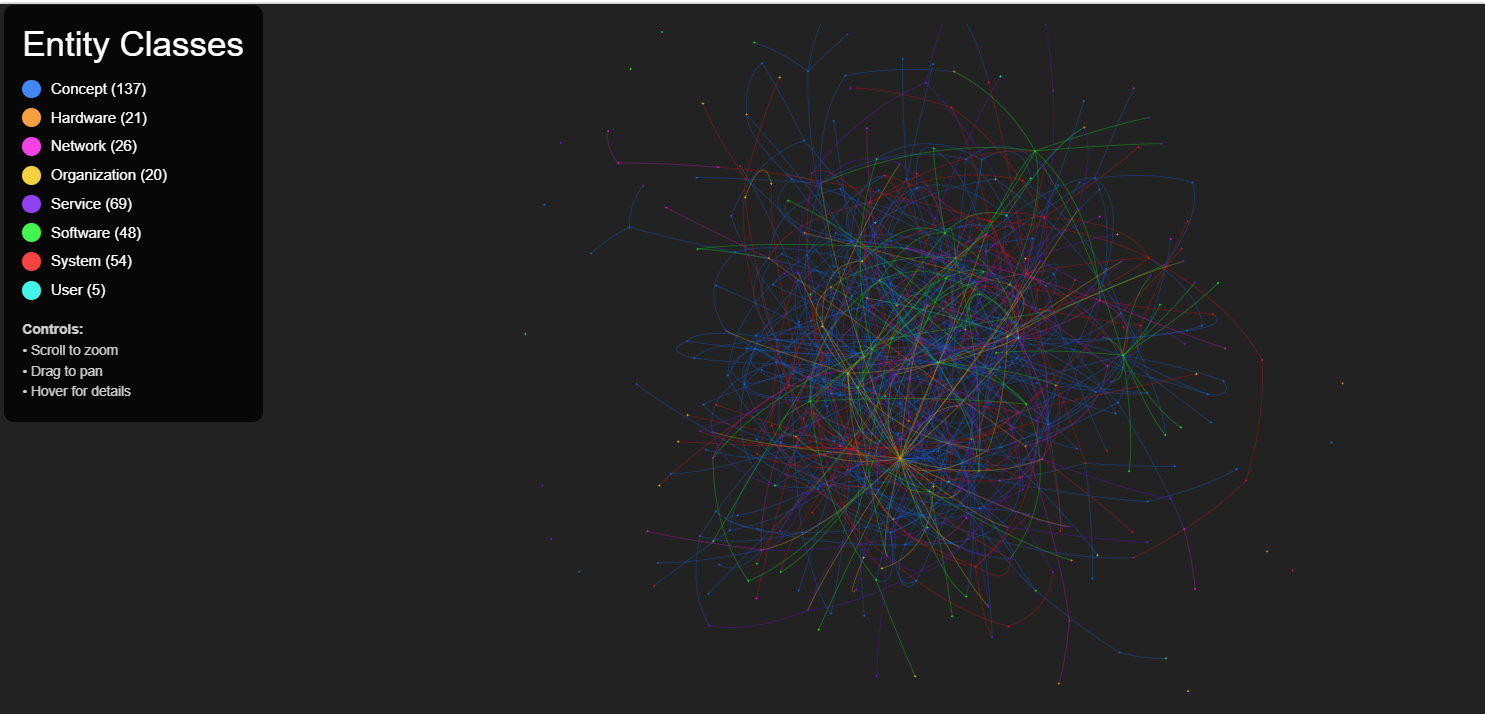

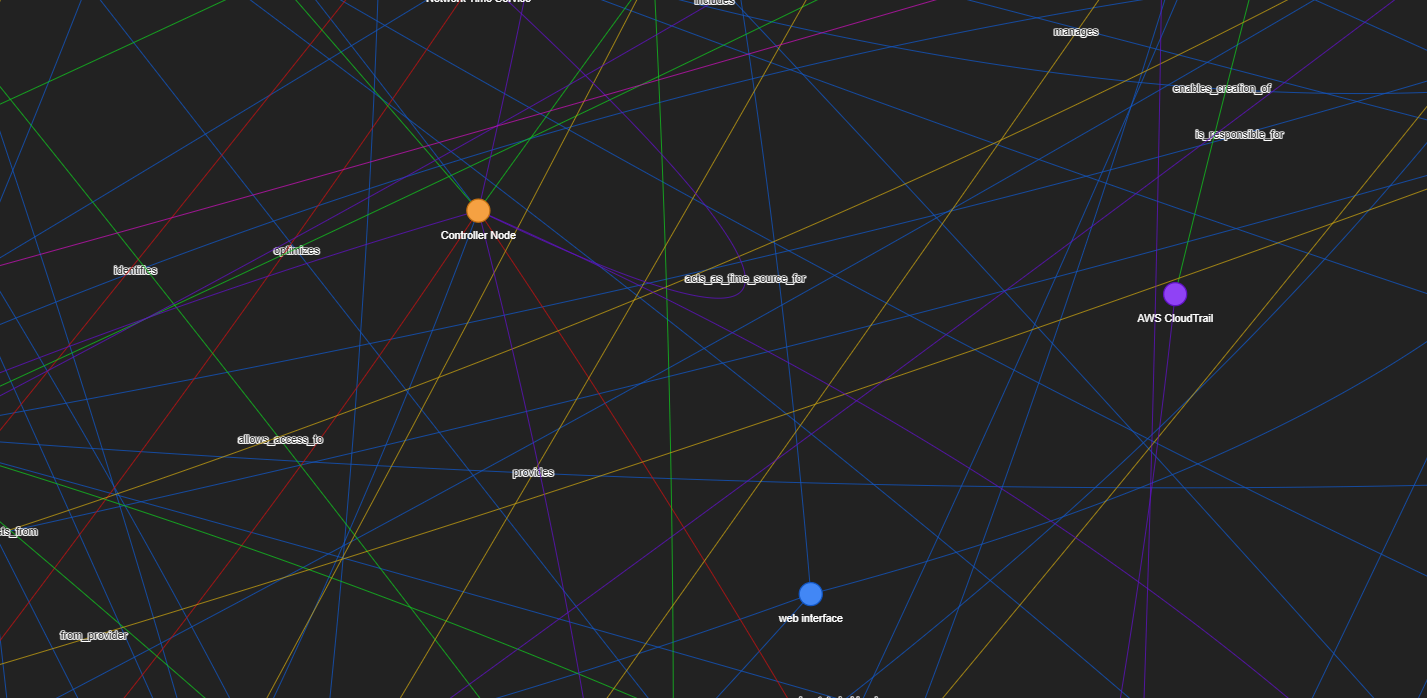